#### Imports

In [1]:
import pandas as pd
import os
import cProfile
import re
import sys
from pathlib import Path
from datetime import datetime
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

notebook_dir = Path().resolve()
pyres_dir = str(notebook_dir.parent) + "/PyRes"
sys.path.append(pyres_dir)
import pyres_fof

os.environ["TPTP"] = str(notebook_dir) + "/TPTP-v9.0.0"

## Data sources

### Data source 1: Previous PyRes run on TPTP

In [8]:
df_tptp_pyres = pd.read_csv(
    "../notes/meeting/protocol_default.csv",
    comment="#",
    sep='\\s+')
df_tptp_pyres["Usertime"] = df_tptp_pyres["Usertime"].round(decimals=0)
df_tptp_pyres = df_tptp_pyres.sort_values("Usertime", ascending=False)

df_tptp_pyres

,Problem,Status,Usertime,Failure,Version,Preprocessingtime,Backward_subsumed,Factors_computed,Forward_subsumed,Initial_clauses,Processed_clauses,Resolvents_computed,Systemtime,Tautologies_deleted,Totaltime
13131,SWV194+1.p,T,99.852,success,1.2,-,4,1,1960,357,2166,98975,0.371,2,100.223
5358,LAT261-1.p,T,99.759,success,1.2,-,12,5,5673,3038,3687,61459,0.138,72,99.897
11919,SWB011+1.p,T,99.539,success,1.2,-,25,198,4675,1281,3675,43267,0.120,58,99.659
5094,LAT005-2.p,T,98.176,success,1.2,-,55,0,4391,31,3966,9397,0.032,339,98.208
2021,FLD021-3.p,T,97.506,success,1.2,-,6,8,96,30,1970,277716,0.371,10,97.877
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5722,LAT362+3.p,F,-,unknown,1.2,-,-,-,-,-,-,-,-,-,-
5723,LAT362+4.p,F,-,unknown,1.2,-,-,-,-,-,-,-,-,-,-
5724,LAT363+1.p,F,-,unknown,1.2,-,-,-,-,-,-,-,-,-,-
5725,LAT363+2.p,F,-,unknown,1.2,-,-,-,-,-,-,-,-,-,-


### Data source 2: TPTP problem files

#### Step 1: Gather data

In [ ]:
load_from_file = True
if load_from_file:
    df_tptp = pd.read_csv("../src/all_problems.csv", index_col=0)
else:
    patterns = {
        "spc": r"(?<=% SPC      :)(\s+\w+)",
        "n_formulae": r"(?<=formulae    :)(\s+\d+)",
        "n_atoms": r"(?<=atoms       :)(\s+\d+)",
    }
    problem_configs = []

    problems_dir = "TPTP-v9.0.0/Problems/"
    dir_list = os.listdir(problems_dir)
    for dir_name in tqdm(dir_list, total=len(dir_list)):
        full_dir_name = os.path.join(problems_dir, dir_name)
        downloads_list = os.listdir(full_dir_name)
        for dir_name in downloads_list:
            full_file_name = os.path.join(full_dir_name, dir_name)
            if not os.path.isfile(full_file_name):
                continue
            with open(full_file_name) as full_file_name:
                s_mp_runs = full_file_name.read()
                problem_results: dict = {
                    "Problem": dir_name,
                }
                for identifier, pattern in patterns.items():
                    re_match = re.search(pattern, s_mp_runs)
                    problem_results[identifier] = re_match.group(0) if re_match is not None else None
                problem_results["full_file_name"] = full_file_name
                problem_configs.append(problem_results)

    df_tptp = pd.DataFrame.from_records(problem_configs)
df_tptp = df_tptp.fillna(value=np.nan)
df_tptp.to_csv("problems.csv")


df_tptp

,Problem,spc,n_formulae,n_atoms,contains_include,full_file_name
0,TOP036+4.p,FOF_THM_RFO_SEQ,34431.0,241872.0,NaN,TPTP-v9.0.0/Problems/TOP/TOP036+4.p
1,TOP029+1.p,FOF_THM_RFO_SEQ,109.0,569.0,NaN,TPTP-v9.0.0/Problems/TOP/TOP029+1.p
2,TOP042+3.p,FOF_THM_RFO_SEQ,13534.0,83921.0,NaN,TPTP-v9.0.0/Problems/TOP/TOP042+3.p
3,TOP008-1.p,CNF_SAT_RFO_NEQ,NaN,NaN,NaN,TPTP-v9.0.0/Problems/TOP/TOP008-1.p
4,TOP009-1.p,CNF_SAT_RFO_NEQ,NaN,NaN,NaN,TPTP-v9.0.0/Problems/TOP/TOP009-1.p
...,...,...,...,...,...,...
26272,MED007+1.p,FOF_THM_RFO_NEQ,41.0,201.0,NaN,TPTP-v9.0.0/Problems/MED/MED007+1.p
26273,MED006+1.p,FOF_THM_RFO_NEQ,41.0,197.0,NaN,TPTP-v9.0.0/Problems/MED/MED006+1.p
26274,MED012+1.p,FOF_SAT_RFO_NEQ,40.0,190.0,NaN,TPTP-v9.0.0/Problems/MED/MED012+1.p
26275,MED008+1.p,FOF_THM_RFO_NEQ,41.0,197.0,NaN,TPTP-v9.0.0/Problems/MED/MED008+1.p


#### Step 2: Filter data

In [10]:
df_tptp = (
    df_tptp
    [ df_tptp["Problem"].str.contains("\\+|\\-", regex=True)
    & df_tptp["spc"].str.contains("NEQ")
    & df_tptp["n_formulae"].notna()
    & df_tptp["n_atoms"].notna() ]
    .reset_index(drop=True)
)
df_tptp.sort_values(by="n_formulae", ascending=False)

,Problem,spc,n_formulae,n_atoms,contains_include,full_file_name
1547,NLP262+1.p,FOF_THM_RFO_NEQ,1026861.0,1026865.0,NaN,TPTP-v9.0.0/Problems/NLP/NLP262+1.p
1559,NLP260+1.p,FOF_THM_RFO_NEQ,1026861.0,1026865.0,NaN,TPTP-v9.0.0/Problems/NLP/NLP260+1.p
1556,NLP261+1.p,FOF_THM_RFO_NEQ,1026861.0,1026865.0,NaN,TPTP-v9.0.0/Problems/NLP/NLP261+1.p
1551,NLP263+1.p,FOF_SAT_RFO_NEQ,1026857.0,1026857.0,NaN,TPTP-v9.0.0/Problems/NLP/NLP263+1.p
1936,MED011+1.p,FOF_SAT_RFO_NEQ,568530.0,568530.0,NaN,TPTP-v9.0.0/Problems/MED/MED011+1.p
...,...,...,...,...,...,...
1025,SYN504+1.p,FOF_THM_EPR_NEQ,1.0,773.0,NaN,TPTP-v9.0.0/Problems/SYN/SYN504+1.p
1024,SYN510+1.p,FOF_THM_EPR_NEQ,1.0,720.0,NaN,TPTP-v9.0.0/Problems/SYN/SYN510+1.p
1023,SYN048+1.p,FOF_THM_EPR_NEQ,1.0,2.0,NaN,TPTP-v9.0.0/Problems/SYN/SYN048+1.p
1021,SYN921+1.p,FOF_THM_EPR_NEQ,1.0,4.0,NaN,TPTP-v9.0.0/Problems/SYN/SYN921+1.p


### General Starexec output stuff

#### Move problem outputs from Downloads to project

In [2]:
import shutil

source_dir = str(notebook_dir.parents[2]) + "/Downloads/"
downloads_list = os.listdir(source_dir)
is_problem = re.compile(r'Job\d+_output*')
problem_outputs = [d for d in downloads_list if is_problem.match(d)]

destination = os.path.join(notebook_dir, "starexec_outputs")
problem_folder = os.path.join(destination, "Job5010_output/")

for dir_name in tqdm(problem_outputs):
    full_dirname = os.path.join(source_dir, dir_name)
    shutil.copytree(full_dirname, destination, dirs_exist_ok=True)
    shutil.rmtree(full_dirname)

print(f"Moved {len(problem_outputs)} folders.")


0it [00:00, ?it/s]

Moved 0 folders.


### Data source 3: StarExec csv output

In [13]:
df_se_csv = pd.read_csv(problem_folder + "Job5010_info.csv")
df_se_csv[df_se_csv["result"]==df_se_csv["expected"]]

,pair id,benchmark,benchmark id,solver,solver id,configuration,configuration id,status,cpu time,wallclock time,memory usage,result,expected,SZSResult,SZSOutput,SZSStatus
0,124991892,jannis_gehring/TPTP v9.0.0/Problems/KRS/KRS001...,4176249,pyres_correct_szs,3675,PyRes_default,398193,complete,1.961070,0.892533,323432.0,Unsatisfiable,Unsatisfiable,UNS-Ass,Ass,UNS
1,124991893,jannis_gehring/TPTP v9.0.0/Problems/KRS/KRS002...,4176250,pyres_correct_szs,3675,PyRes_default,398193,complete,2.883700,1.047470,323432.0,Unsatisfiable,Unsatisfiable,UNS-Ass,Ass,UNS
4,124991896,jannis_gehring/TPTP v9.0.0/Problems/KRS/KRS003...,4176253,pyres_correct_szs,3675,PyRes_default,398193,complete,2.303760,0.808196,4609600.0,Unsatisfiable,Unsatisfiable,UNS-Ass,Ass,UNS
5,124991897,jannis_gehring/TPTP v9.0.0/Problems/KRS/KRS004...,4176254,pyres_correct_szs,3675,PyRes_default,398193,complete,0.525020,0.705278,323432.0,Unsatisfiable,Unsatisfiable,UNS-Ass,Ass,UNS
6,124991898,jannis_gehring/TPTP v9.0.0/Problems/KRS/KRS005...,4176255,pyres_correct_szs,3675,PyRes_default,398193,complete,0.831297,0.685208,323432.0,Satisfiable,Satisfiable,SAT-Ass,Ass,SAT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12109,125004001,jannis_gehring/TPTP v9.0.0/Problems/KLE/KLE001...,4175992,pyres_correct_szs,3675,PyRes_default,398193,complete,5.335240,1.420810,3792760.0,Theorem,Theorem,THM-Ass,Ass,THM
12111,125004003,jannis_gehring/TPTP v9.0.0/Problems/KLE/KLE003...,4175994,pyres_correct_szs,3675,PyRes_default,398193,complete,10.880700,3.032260,5087264.0,Theorem,Theorem,THM-Ass,Ass,THM
12113,125004005,jannis_gehring/TPTP v9.0.0/Problems/KLE/KLE005...,4175996,pyres_correct_szs,3675,PyRes_default,398193,complete,82.856300,11.771300,9196756.0,Theorem,Theorem,THM-Ass,Ass,THM
12202,125004094,jannis_gehring/TPTP v9.0.0/Problems/KLE/KLE051...,4176085,pyres_correct_szs,3675,PyRes_default,398193,complete,9.821320,2.549990,6855000.0,Theorem,Theorem,THM-Ass,Ass,THM


### Data source 4: StarExec individual job files

#### Extract texts from files to pandas dataframe

In [79]:
print(f"Searching in {problem_folder}")
file_dir_names = [
    subdir+"/"+files[0]
    for (subdir, dirs, files) in os.walk(problem_folder + "jannis_gehring")
    if len(dirs)==0
]

patterns = {
    "problem_name": r"(?<=Problem    : )(.*)(?= : )",
}

texts = []
for full_file_name in tqdm(file_dir_names):
    if not os.path.isfile(full_file_name):
        texts.append(None)
        continue
    with open(full_file_name) as full_file_name:
        s_mp_runs = full_file_name.read()
        texts.append(s_mp_runs)

df_se_indi = pd.DataFrame({
    "file_dir_name": file_dir_names,
    "text": texts,
})
df_se_indi


Searching in /Users/jannisgehring/VSCode/coursework-pyres/src/starexec_outputs/Job5010_output/


100%|██████████| 12366/12366 [00:01<00:00, 8440.19it/s] 


,file_dir_name,text
0,/Users/jannisgehring/VSCode/coursework-pyres/s...,0.05/0.12\t% Problem : ITP088^7 : TPTP v9.0...
1,/Users/jannisgehring/VSCode/coursework-pyres/s...,0.02/0.12\t% Problem : ITP069_5 : TPTP v9.0...
2,/Users/jannisgehring/VSCode/coursework-pyres/s...,0.07/0.09\t% Problem : ITP087^4 : TPTP v9.0...
3,/Users/jannisgehring/VSCode/coursework-pyres/s...,0.03/0.11\t% Problem : ITP122^7 : TPTP v9.0...
4,/Users/jannisgehring/VSCode/coursework-pyres/s...,0.07/0.12\t% Problem : ITP068^4 : TPTP v9.0...
...,...,...
12361,/Users/jannisgehring/VSCode/coursework-pyres/s...,0.08/0.11\t% Problem : ALG167+1 : TPTP v9.0...
12362,/Users/jannisgehring/VSCode/coursework-pyres/s...,0.07/0.11\t% Problem : ALG387-1 : TPTP v9.0...
12363,/Users/jannisgehring/VSCode/coursework-pyres/s...,0.03/0.11\t% Problem : ALG248^3 : TPTP v9.0...
12364,/Users/jannisgehring/VSCode/coursework-pyres/s...,0.06/0.11\t% Problem : Problem\n0.06/0.12\t...


#### Add columns from regex

In [83]:
def extract_regex(pattern, text):
    all_matches = re.findall(pattern, text)
    if len(all_matches)>0:
        return all_matches[0]
    else:
        return None

def add_column_by_regex(df, new_column_name, pattern):
    df[new_column_name] = (
        df["text"]
        .apply(lambda text:
            extract_regex(pattern, text)
        )
    )
    return df

new_column_specs = [
    ("problem",  r"(?<=Problem    : )(.*)(?= : )"),
    ("mp_runs",  r"(?<=\d\t)\[.*\]"),
    # todo: fix: this regex patterns doesnt allow for lines starting with 79.84/10.64
]
for new_column_name, pattern in new_column_specs:
    add_column_by_regex(df_se_indi, new_column_name, pattern)

df_se_indi


,file_dir_name,text,problem,mp_runs
0,/Users/jannisgehring/VSCode/coursework-pyres/s...,0.05/0.12\t% Problem : ITP088^7 : TPTP v9.0...,ITP088^7,None
1,/Users/jannisgehring/VSCode/coursework-pyres/s...,0.02/0.12\t% Problem : ITP069_5 : TPTP v9.0...,ITP069_5,None
2,/Users/jannisgehring/VSCode/coursework-pyres/s...,0.07/0.09\t% Problem : ITP087^4 : TPTP v9.0...,ITP087^4,None
3,/Users/jannisgehring/VSCode/coursework-pyres/s...,0.03/0.11\t% Problem : ITP122^7 : TPTP v9.0...,ITP122^7,None
4,/Users/jannisgehring/VSCode/coursework-pyres/s...,0.07/0.12\t% Problem : ITP068^4 : TPTP v9.0...,ITP068^4,None
...,...,...,...,...
12361,/Users/jannisgehring/VSCode/coursework-pyres/s...,0.08/0.11\t% Problem : ALG167+1 : TPTP v9.0...,ALG167+1,None
12362,/Users/jannisgehring/VSCode/coursework-pyres/s...,0.07/0.11\t% Problem : ALG387-1 : TPTP v9.0...,ALG387-1,None
12363,/Users/jannisgehring/VSCode/coursework-pyres/s...,0.03/0.11\t% Problem : ALG248^3 : TPTP v9.0...,ALG248^3,None
12364,/Users/jannisgehring/VSCode/coursework-pyres/s...,0.06/0.11\t% Problem : Problem\n0.06/0.12\t...,None,None


#### Filter

In [79]:
df_se_indi = (
    df_se_indi
    [
        df_se_indi["problem"].notnull()
        & df_se_indi["mp_runs"].notnull()
        & ~df_se_indi["problem"].str.contains("\\_|\\^", regex=True, na=True)
        & df_se_indi["problem"].str.contains("\\+|\\-", regex=True)
    ]
    [["problem", "mp_runs", "file_dir_name", "text"]]
)
df_se_indi.to_csv("temp.csv")
df_se_indi

,problem,mp_runs,file_dir_name,text
121,ITP002+5,"[(1, True, 'SZS status GaveUp'), (2, True, 'SZ...",/Users/jannisgehring/VSCode/coursework-pyres/s...,0.12/0.12\t% Problem : ITP002+5 : TPTP v9.0...
132,ITP001+2,"[(1, True, 'SZS status GaveUp'), (2, True, 'SZ...",/Users/jannisgehring/VSCode/coursework-pyres/s...,0.07/0.12\t% Problem : ITP001+2 : TPTP v9.0...
173,ITP111+5,"[(1, True, 'SZS status GaveUp'), (2, True, 'SZ...",/Users/jannisgehring/VSCode/coursework-pyres/s...,0.08/0.11\t% Problem : ITP111+5 : TPTP v9.0...
197,ITP002+4,"[(1, True, 'SZS status GaveUp'), (2, True, 'SZ...",/Users/jannisgehring/VSCode/coursework-pyres/s...,0.00/0.12\t% Problem : ITP002+4 : TPTP v9.0...
285,ITP035+5,"[(1, True, 'SZS status GaveUp'), (2, True, 'SZ...",/Users/jannisgehring/VSCode/coursework-pyres/s...,0.00/0.11\t% Problem : ITP035+5 : TPTP v9.0...
...,...,...,...,...
12194,ALG326-1,"[(1, True, 'SZS status GaveUp'), (2, True, 'SZ...",/Users/jannisgehring/VSCode/coursework-pyres/s...,0.06/0.11\t% Problem : ALG326-1 : TPTP v9.0...
12198,ALG332-1,"[(1, True, 'SZS status GaveUp'), (2, True, 'SZ...",/Users/jannisgehring/VSCode/coursework-pyres/s...,0.12/0.12\t% Problem : ALG332-1 : TPTP v9.0...
12212,ALG333-1,"[(1, True, 'SZS status GaveUp'), (2, True, 'SZ...",/Users/jannisgehring/VSCode/coursework-pyres/s...,0.07/0.12\t% Problem : ALG333-1 : TPTP v9.0...
12215,ALG327-1,"[(1, True, 'SZS status GaveUp'), (2, True, 'SZ...",/Users/jannisgehring/VSCode/coursework-pyres/s...,0.07/0.12\t% Problem : ALG327-1 : TPTP v9.0...


#### Evaluate mp_runs infos

In [85]:
import ast

def get_rel_runs_infos(text: str) -> int:
    if text is None:
        return None, None
    data = list(ast.literal_eval(text))
    df = pd.DataFrame(
        data,
        columns=["rel_distance", "terminated", "szs_status"]
    )
    df_unsats = df[df["szs_status"].str.contains("Unsat", na=False)]
    r_of_first_unsat = df_unsats.iloc[0]["rel_distance"] if not df_unsats.empty else None
    szs_status_of_max_r = df.iloc[-1]["szs_status"] if not df.empty else None
    return r_of_first_unsat, szs_status_of_max_r

df_se_indi["r_of_first_unsat"], df_se_indi["szs_status_of_max_r"] =\
    zip(*df_se_indi["mp_runs"].apply(get_rel_runs_infos))

df_se_indi

,file_dir_name,text,problem,mp_runs,r_of_first_unsat,szs_status_of_max_r
0,/Users/jannisgehring/VSCode/coursework-pyres/s...,0.05/0.12\t% Problem : ITP088^7 : TPTP v9.0...,ITP088^7,None,NaN,None
1,/Users/jannisgehring/VSCode/coursework-pyres/s...,0.02/0.12\t% Problem : ITP069_5 : TPTP v9.0...,ITP069_5,None,NaN,None
2,/Users/jannisgehring/VSCode/coursework-pyres/s...,0.07/0.09\t% Problem : ITP087^4 : TPTP v9.0...,ITP087^4,None,NaN,None
3,/Users/jannisgehring/VSCode/coursework-pyres/s...,0.03/0.11\t% Problem : ITP122^7 : TPTP v9.0...,ITP122^7,None,NaN,None
4,/Users/jannisgehring/VSCode/coursework-pyres/s...,0.07/0.12\t% Problem : ITP068^4 : TPTP v9.0...,ITP068^4,None,NaN,None
...,...,...,...,...,...,...
12361,/Users/jannisgehring/VSCode/coursework-pyres/s...,0.08/0.11\t% Problem : ALG167+1 : TPTP v9.0...,ALG167+1,None,NaN,None
12362,/Users/jannisgehring/VSCode/coursework-pyres/s...,0.07/0.11\t% Problem : ALG387-1 : TPTP v9.0...,ALG387-1,None,NaN,None
12363,/Users/jannisgehring/VSCode/coursework-pyres/s...,0.03/0.11\t% Problem : ALG248^3 : TPTP v9.0...,ALG248^3,None,NaN,None
12364,/Users/jannisgehring/VSCode/coursework-pyres/s...,0.06/0.11\t% Problem : Problem\n0.06/0.12\t...,None,None,NaN,None


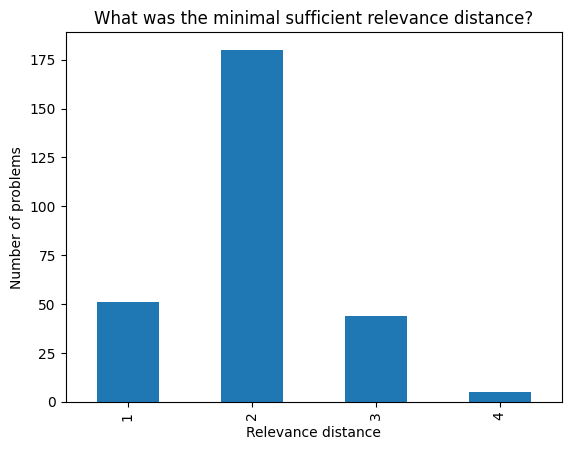

In [86]:
(
    df_se_indi
    [df_se_indi["r_of_first_unsat"].notnull()]
    ["r_of_first_unsat"]
    .astype(int)
    .value_counts()
    .sort_index()
    .plot(
        title="What was the minimal sufficient relevance distance?",
        xlabel="Relevance distance",
        ylabel="Number of problems",
        kind="bar",
    )
)
plt.show()

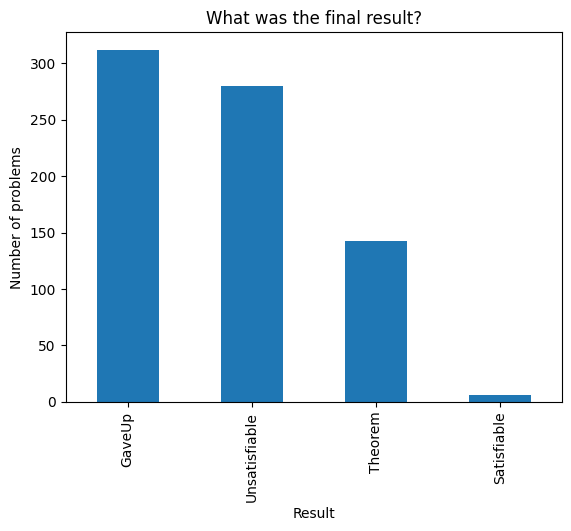

In [87]:
(
    df_se_indi
    [df_se_indi["szs_status_of_max_r"].notnull()]
    ["szs_status_of_max_r"]
    .apply(lambda text: text.replace("SZS status ", ""))
    .value_counts()
    .sort_values(ascending=False)
    .plot(
        title="What was the final result?",
        xlabel="Result",
        ylabel="Number of problems",
        kind="bar",
    )
)
plt.show()

In [100]:
print(list(df_se_indi.columns))

# All problems
no_filters = df_se_indi.copy(deep=True)
no_filters_ctr = len(no_filters)

# Suitable for PyRes
suitable = (
    no_filters
    [
        df_se_indi["problem"].notnull()
        & ~df_se_indi["problem"].str.contains("\\_|\\^", regex=True, na=True)
        & df_se_indi["problem"].str.contains("\\+|\\-", regex=True)
    ]
)
suitable_ctr = len(suitable)

# Multiprocessing runs available
mp_runs_available = suitable[suitable["mp_runs"].notnull()]
mp_runs_available_ctr = len(mp_runs_available)
mp_runs_not_available = suitable[~suitable["mp_runs"].notnull()]

def perform_regex_subfiltering(super_df: pd.DataFrame, pattern, return_dfs=False):
    sub_df_index = (
        super_df["text"].apply(
            lambda text: bool(re.search(pattern, text))
        )
    )
    sub_df = super_df[sub_df_index]
    sub_df_ctr = len(sub_df)
    sub_df_not = super_df[~sub_df_index]

    return (
        sub_df_ctr, sub_df, sub_df_not
        if return_dfs else sub_df_ctr
    )

# Resource out
resource_out_ctr, resource_out, resource_not_out\
    = perform_regex_subfiltering(mp_runs_not_available,
                                 r'Resource limit exceeded',
                                 return_dfs=True)

# Traceback
traceback_ctr, traceback, no_traceback\
    = perform_regex_subfiltering(resource_not_out,
                                 r'Traceback \(most recent call last\)',
                                 return_dfs=True)

# Alarm clock
clock_ctr, clock, no_clock\
    = perform_regex_subfiltering(no_traceback,
                                 r'\d\tAlarm clock',
                                 return_dfs=True)


# SZS status inappropriate
inaproppriate_ctr, inaproppriate, not_inappropriate\
    = perform_regex_subfiltering(no_clock,
                                 r'\d\t% SZS status Inappropriate',
                                 return_dfs=True)

not_inappropriate["text"].apply(print)

sets = {
    "All": no_filters_ctr,
    "Suitable for PyRes":suitable_ctr,
    "Not suitable for PyRes":(not_suitable_ctr:=no_filters_ctr-suitable_ctr),
    "Multiprocessing runs available":mp_runs_available_ctr,
}

for key, value in sets.items():
    print(f"{key}: {value}")

['file_dir_name', 'text', 'problem', 'mp_runs', 'r_of_first_unsat', 'szs_status_of_max_r']
0.06/0.15	% Problem    : ITP080+5 : TPTP v9.0.0. Bugfixed v7.5.0.
0.06/0.16	Python 3.6.8
0.06/0.16	% Command    :  python3 ./pyres-fof-mp.py -tifbsVp -nlargest -HPickGiven5 /export/starexec/sandbox/benchmark/theBenchmark.ax
0.11/0.42	Computer   : n029.cluster.edu
0.11/0.42	Model      : x86_64 x86_64
0.11/0.42	CPUModel   : Intel(R) Xeon(R) CPU E5-2620 v4 @ 2.10GHz
0.11/0.42	RAMPerCPU  : 8042.1875MB
0.11/0.42	OS         : Linux 3.10.0-693.el7.x86_64
0.11/0.42	% CPULimit   : 300
0.11/0.42	% DateTime   : Tue Feb 11 04:06:10 EST 2025
0.11/0.42	% CPUTime    : 
94.57/94.85	% Version:  1.5
225.79/115.70	EOF

0.10/0.11	% Problem    : ITP146+4 : TPTP v9.0.0. Bugfixed v7.5.0.
0.10/0.12	Python 3.6.8
0.10/0.13	% Command    :  python3 ./pyres-fof-mp.py -tifbsVp -nlargest -HPickGiven5 /export/starexec/sandbox2/benchmark/theBenchmark.ax
0.12/0.33	Computer   : n014.cluster.edu
0.12/0.33	Model      : x86_64 x86_64

In [114]:
import plotly.graph_objects as go

read_from_csv = True
store = False
sankey_csv_path = problem_folder + "/sankey_data.csv"

if read_from_csv:
  df_filterings = pd.read_csv(sankey_csv_path, index_col=0)
else:
  filterings = [
    # (from, to, thickness),
    ("All", "Suitable for PyRes", suitable_ctr),
    ("All", "Unsuitable for PyRes", no_filters_ctr-suitable_ctr),
    ("Suitable for PyRes", "Multiprocessing runs available", mp_runs_available_ctr),
    ("Suitable for PyRes", "Resource out", resource_out_ctr),
    ("Suitable for PyRes", "Traceback", traceback_ctr),
    ("Suitable for PyRes", "Alarm Clock", clock_ctr),
    ("Suitable for PyRes", "SZS Status Inaproppriate", inaproppriate_ctr),
  ]
  df_filterings = pd.DataFrame(filterings, columns=["source", "target", "value"])
  if store:
    df_filterings.to_csv(sankey_csv_path)

labels = np.unique(df_filterings[["source", "target"]].values).tolist()

for column_name in ["source", "target"]:
  df_filterings[column_name] =\
    df_filterings[column_name].apply(lambda x: labels.index(x))

sources, targets, values = [
  df_filterings[col].to_list()
  for col in
  df_filterings.columns
]

fig = go.Figure(data=[go.Sankey(
    node = dict(
      pad = 15,
      thickness = 20,
      line = dict(color = "black", width = 0.5),
      label = labels,
      color = "blue"
    ),
    link = dict(
      source = sources,
      target = targets,
      value = values,
))])
fig.show()



## Profiling

In [ ]:
opts = [
    ("-s", ""),
    ("-r", "5"),
]
problem_dir = df_tptp["full_file_name"][1000]
problem_name = problem_dir[problem_dir.rindex("/")+1:]
args = [
    problem_dir
    # "TPTP-v9.0.0/Problems/AGT/AGT042+1.p"
    # pyres_dir + "/EXAMPLES/PUZ001+1.p"
    # "TPTP-v9.0.0/Problems/MED/MED007+1.p"
    # "TPTP-v9.0.0/Problems/CSR/CSR038+3.p"

]

with cProfile.Profile() as pr:
    pyres_fof.main(from_notebook=True, notebook_opts=opts, notebook_args=args)
    df_function_stats = pd.DataFrame(
        pr.getstats(),
        columns=["func", "ncalls", "ccalls",
                 "tottime", "cumtime", "callers"]
    )
df_function_stats["func"] = df_function_stats["func"].astype(str)
df_function_stats = \
    df_function_stats[ \
        df_function_stats["func"].str.contains(r"PyRes/(\w+)\.py") ]

func_names = []
lines = []
for value in df_function_stats["func"]:
    func_name = re.search(r'(?<=code object )(\w+)', value)
    line = re.search(r'(?<=line )(\d+)', value)
    func_names.append(func_name.group() if func_name is not None else None)
    lines.append(int(line.group()) if line is not None else None)
df_function_stats["func_name"] = func_names
df_function_stats["line"] = lines

df_function_stats = (
        df_function_stats[["func_name", "line", "ncalls", "ccalls",
                  "tottime", "cumtime", "func", "callers"]]
        .sort_values("ncalls", ascending=False)
)


datestring = (
    datetime.now().isoformat()
    .replace("2025-", "")
)
datestring = datestring[:datestring.rindex(".")]

df_function_stats.to_csv(
    str(notebook_dir)
    + f"/profiling/{datestring}_{problem_name}.csv"
    .replace(".p", "")
)
df_function_stats

TPTP-v9.0.0/Problems/SYN/SYN063+1.p
SYN063+1.p
% SZS status Theorem

% Initial clauses    : 31
% Processed clauses  : 42
% Factors computed   : 35
% Resolvents computed: 891
% Tautologies deleted: 0
% Forward subsumed   : 0
% Backward subsumed  : 0
% -------- CPU Time ---------
% User time          : 14.561 s
% System time        : 0.810 s
% Total time         : 15.371 s


/var/folders/pb/8wrfvtz5593cjrgr_g89r70m0000gn/T/ipykernel_55361/2534231915.py:26: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df_stats = df_stats[ df_stats["func"].str.contains(r"PyRes/(\w+)\.py") ]


,func_name,line,ncalls,ccalls,tottime,cumtime,func,callers
259,termIsVar,73,355727,0,8.787824e-02,8.776720e-02,"<code object termIsVar at 0x107ac1430, file ""/...",[(<code object _clean_thread_parent_frames at ...
284,termIsCompound,81,240897,0,1.244782e-01,6.480846e-02,"<code object termIsCompound at 0x107ae93e0, fi...","[(<code object __or__ at 0x100a85f10, file ""/o..."
260,termFunc,89,106631,0,8.895831e-02,3.291471e-02,"<code object termFunc at 0x107ac1530, file ""/U...",[(<method '__exit__' of 'sqlite3.Connection' o...
261,termArgs,97,70662,0,6.247266e-02,2.770090e-02,"<code object termArgs at 0x107ac1630, file ""/U...",[(<method 'popleft' of 'collections.deque' obj...
285,isNegative,184,40132,0,4.009462e-03,4.009462e-03,"<code object isNegative at 0x107ae94d0, file ""...",None
...,...,...,...,...,...,...,...,...
195,formulaCNFSplit,640,1,0,6.356660e-04,3.738300e-05,"<code object formulaCNFSplit at 0x107947c10, f...","[(<code object getMatrix at 0x1078d6b80, file ..."
193,tptpLexer,49,1,0,2.320000e-04,5.520900e-05,"<code object tptpLexer at 0x107946870, file ""/...","[(<code object __or__ at 0x100a85f10, file ""/o..."
192,addEqAxioms,160,1,0,1.545420e-04,3.041000e-06,"<code object addEqAxioms at 0x107943850, file ...","[(<code object __init__ at 0x107ae8d50, file ""..."
219,getName,197,1,0,2.500000e-07,2.500000e-07,"<code object getName at 0x107a3e100, file ""/Us...",None


#### Filter for alternating path functions 

In [10]:
df_function_stats = pd.read_csv("profiling/profiling_runs.csv", index_col=0)
df_function_stats[ df_function_stats["func"].str.contains("alternatingpath.py") ]

,func_name,line,ncalls,ccalls,tottime,cumtime,func,callers
235,edge_neighb_of_subset,91,8004594,0,0.729436,0.729436,<code object edge_neighb_of_subset at 0x104c1b...,NaN
280,NaN,98,8004594,0,2.787934,2.058498,"<code object <lambda> at 0x104c79200, file ""/U...",[_lsprof.profiler_subentry(code=<code object e...
279,__init__,19,5006,0,0.000657,0.000657,"<code object __init__ at 0x104c79110, file ""/U...",NaN
278,__init__,9,1702,0,0.000144,0.000144,"<code object __init__ at 0x104c79020, file ""/U...",NaN
272,NaN,87,1702,0,0.000163,0.000163,"<code object <lambda> at 0x104c52b30, file ""/U...",NaN
284,get_neighbours,95,1599,0,4.077462,1.289528,"<code object get_neighbours at 0x104c983b0, fi...",[_lsprof.profiler_subentry(code=<code object <...
270,get_all_nodes,73,1,0,0.000036,0.000036,"<code object get_all_nodes at 0x104c52230, fil...",NaN
163,construct_betweenclause_edges,57,1,0,5.855480,0.215930,<code object construct_betweenclause_edges at ...,[_lsprof.profiler_subentry(code=<code object t...
196,nodes_to_clauses,76,1,0,0.000007,0.000006,"<code object nodes_to_clauses at 0x1043e8030, ...",[_lsprof.profiler_subentry(code=<code object _...
199,get_rel_neighbourhood,109,1,0,4.080163,0.002488,<code object get_rel_neighbourhood at 0x1043f3...,[_lsprof.profiler_subentry(code=<code object c...
